# Comparing the output distirbutions of different Generative Methods

In [15]:
import torch
import numpy as np
import normflows as nf
import os

from matplotlib import pyplot as plt

from tqdm import tqdm

from jet_dataset import JetDataset
from script_jets import DDPM, SimpleCondFF

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
###################################
### Define the Normalizing Flow ###
###################################

# Define flows
K = 10

latent_size = 1
hidden_units = 64
hidden_layers = 2
context_size = 16

ep = 7499
flow_dir = './data/NF_2_jets15/'

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
flow = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
flow = flow.to(device)
flow.eval()

flow.load_state_dict(torch.load(flow_dir + f"model_{ep}.pth"))
print('loaded model from ' + flow_dir + f"model_{ep}.pth")

loaded model from ./data/NF_2_jets15/model_7499.pth


In [18]:
##################################
### Define the Diffusion Model ###
##################################

n_classes = 10 #have no effect
n_feat = 256 # 128 ok, 256 better (but slower)
n_T = 400 # probably total overkill

ep = 59
diff_dir = './data/diffusion_jets15_great/'

nn_model_class = SimpleCondFF #ContextUnet

ddpm = DDPM(nn_model=nn_model_class(in_channels=1, 
                                    n_feat=n_feat, 
                                    n_classes=n_classes), 
                                    betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.eval()

ddpm.load_state_dict(torch.load(diff_dir + f"model_{ep}.pth"))
print('loaded model from ' + diff_dir + f"model_{ep}.pth")

loaded model from ./data/diffusion_jets15_great/model_59.pth


In [19]:
#######################
### Define the data ###
#######################

dataset_val = JetDataset("./jet_data",'val')

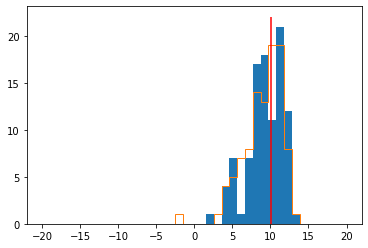

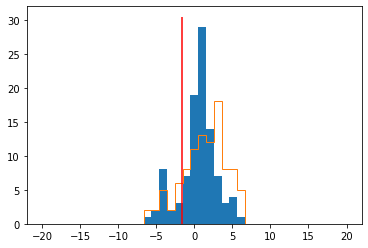

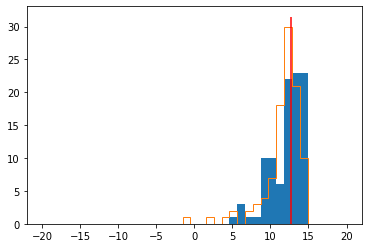

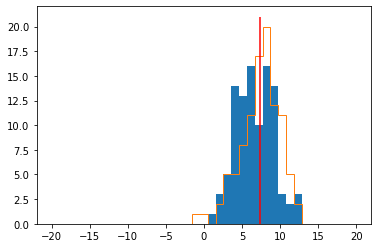

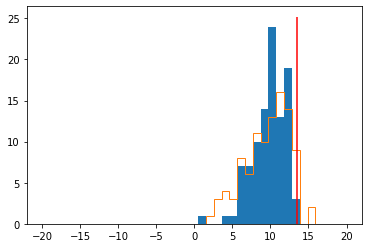

In [20]:
for i in range(5):
    conditions = torch.Tensor(dataset_val.features).to(device)
    n_stat_alea = 100
    bins = np.linspace(-20,20,40)

    x_gen_flow, _ = flow.sample(1*n_stat_alea, context=conditions[i:i+1].repeat_interleave(n_stat_alea, dim=0))
    x_gen_flow *= 20
    plt.hist(x_gen_flow.detach().cpu().numpy(), bins = bins)
    del x_gen_flow

    x_gen_diff, _ = ddpm.sample(conditions[i:i+1].repeat_interleave(n_stat_alea, dim=0), device = device)
    x_gen_diff *= 20
    plt.hist(x_gen_diff.detach().cpu().numpy(), bins = bins, histtype = 'step')
    del x_gen_diff

    plt.vlines(dataset_val.target[i:i+1]*20, *plt.ylim(), color = 'red')
    plt.show()